train set에서 y=0, y=1인 샘플의 수가 일치하도록 음성 샘플을 언더샘플링

------------------------------------------------ 데이터 로딩 ------------------------------------------------ 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

train = pd.read_csv('/Users/jaesolshin/내 드라이브/2024-2/Google ML Bootcamp2024/data/playground1/train.csv')

In [2]:
np.random.seed(42)

# 전체 데이터의 인덱스 생성
indices = np.arange(train.shape[0])

# 99:1 비율로 train, valid 분할
train_id, valid_id = train_test_split(indices, test_size=0.01, random_state=42)

# train에서 sample_t개, valid에서 sample_v개 샘플링
sample_t = 150000
sample_v = 1000
train_sample_id = np.random.choice(train_id, sample_t, replace=False)
valid_sample_id = np.random.choice(valid_id, sample_v, replace=False)

# train_x, train_y, valid_x, valid_y 생성
train_x = train.iloc[train_sample_id, :-1]
train_y = train.iloc[train_sample_id, -1]
valid_x = train.iloc[valid_sample_id, :-1]
valid_y = train.iloc[valid_sample_id, -1]

# y=0과 y=1을 1:1로 언더샘플링
class_0_indices = np.where(train_y == 0)[0]
class_1_indices = np.where(train_y == 1)[0]

# 소수 클래스의 샘플 수를 기준으로 다수 클래스 샘플링
num_class_1 = len(class_1_indices)
undersample_class_0_indices = np.random.choice(class_0_indices, num_class_1, replace=False)

# 언더샘플링된 인덱스 합치기
undersample_indices = np.concatenate([undersample_class_0_indices, class_1_indices])
np.random.shuffle(undersample_indices)

# 언더샘플링된 데이터 생성
train_x = train_x.iloc[undersample_indices]
train_y = train_y.iloc[undersample_indices]

print("Train sample X shape:", train_x.shape)
print("Train sample Y shape:", train_y.shape)
print("Valid sample X shape:", valid_x.shape)
print("Valid sample Y shape:", valid_y.shape)


Train sample X shape: (36490, 11)
Train sample Y shape: (36490,)
Valid sample X shape: (1000, 11)
Valid sample Y shape: (1000,)


------------------------------------------------ 여기서부터 데이터 확인 및 전처리 ------------------------------------------------

In [3]:
train_x.head()
train_x.iloc[:,[1,3,4,5,6,7,9]]


,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel
10796613,Female,1,47.0,0,< 1 Year,Yes,152.0
1940896,Male,1,28.0,1,1-2 Year,No,124.0
3976563,Male,1,43.0,0,1-2 Year,Yes,26.0
8788110,Male,1,3.0,0,1-2 Year,Yes,26.0
3004937,Female,1,41.0,1,< 1 Year,No,152.0
...,...,...,...,...,...,...,...
7711967,Male,1,41.0,0,1-2 Year,Yes,120.0
2885403,Female,1,28.0,1,< 1 Year,No,152.0
5398528,Male,1,35.0,0,1-2 Year,Yes,26.0
9193786,Male,1,41.0,0,1-2 Year,Yes,124.0


In [4]:
# 범주형 변수를 팩터로 변환 (카테고리형)
train_x.iloc[:,[1,3,4,5,6,7,9]].apply(lambda x: x.astype('category'))
valid_x.iloc[:,[1,3,4,5,6,7,9]].apply(lambda x: x.astype('category'))

# 이분변수 생성: "Annual_Premium" == 2630.0 인 경우
train_x['Annual_Premium_Binary'] = (train_x['Annual_Premium'] == 2630.0).astype('category')
valid_x['Annual_Premium_Binary'] = (valid_x['Annual_Premium'] == 2630.0).astype('category')

# 로그 변환된 "Annual_Premium" 변수 생성
train_x['Annual_Premium_Log'] = np.log1p(train_x['Annual_Premium'])
valid_x['Annual_Premium_Log'] = np.log1p(valid_x['Annual_Premium'])

# 정규화
# StandardScaler, MinMaxScaler, RobustScaler 중에서 선택
from sklearn.preprocessing import StandardScaler

# 최소-최대 정규화 (Min-Max 스케일링)
scaler = StandardScaler()
train_x.iloc[:,[2,8,10]] = scaler.fit_transform(train_x.iloc[:,[2,8,10]])
valid_x.iloc[:,[2,8,10]] = scaler.fit_transform(valid_x.iloc[:,[2,8,10]])

# 예측에 필요 없는 'id'와 'Annual_Premium' 변수를 드롭
train_x = train_x.drop(columns=['id', 'Annual_Premium'])
valid_x = valid_x.drop(columns=['id', 'Annual_Premium'])

# 원-핫 인코딩 (One-Hot Encoding)
train_x = pd.get_dummies(train_x, columns=['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Annual_Premium_Binary'])
valid_x = pd.get_dummies(valid_x, columns=['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Annual_Premium_Binary'])

# train_x와 valid_x가 동일한 열을 가지도록 조정
train_x, valid_x = train_x.align(valid_x, join='left', axis=1, fill_value=0)

# XGBoost에서 발생하는 문제 해결
train_x.columns = train_x.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')
valid_x.columns = valid_x.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')



/var/folders/fx/7qldcfl92nb_g9hqp_lrssxm0000gn/T/ipykernel_79429/3505367456.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.18866007  0.53888548 -0.46884943 ...  0.97077187  1.04275294
 -0.46884943]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_x.iloc[:,[2,8,10]] = scaler.fit_transform(train_x.iloc[:,[2,8,10]])
/var/folders/fx/7qldcfl92nb_g9hqp_lrssxm0000gn/T/ipykernel_79429/3505367456.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.42849401 -1.66726237 -1.12689187 ... -0.93839054 -0.03358413
  0.33085179]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_x.iloc[:,[2,8,10]] = scaler.fit_transform(train_x.iloc[:,[2,8,10]])
/var/folders/fx/7qldcfl92nb_g9hqp_lrssxm0000gn/T/ipykernel_79429/3505367456.py:20: FutureWarning: Setting an ite

------------------------------------------------ 이제 드디어 모델링 ------------------------------------------------

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 개별 모델 생성
models = [
    ('Logistic Regression', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)),
    ('Random Forest', RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
    ('LightGBM', LGBMClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42))
]

In [6]:
#평가를 위한 패키지 임포트
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 18245, number of negative: 18245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 36490, number of used features: 105
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

=== Model Results ===
       Confusion Matrix  Accuracy  Precision  Positive Recall  Specificity  F1-Score                Model  Weight (Precision)  Weight (Recall)      AUC
[[580, 306], [11, 103]]     0.683   0.251834         0.903509     0.654628  0.393881  Logistic Regression            0.200598         0.199226 0.843006
[[588, 298], [13, 101]]     0.689   0.253133         0.885965     0.663657  0.393762      

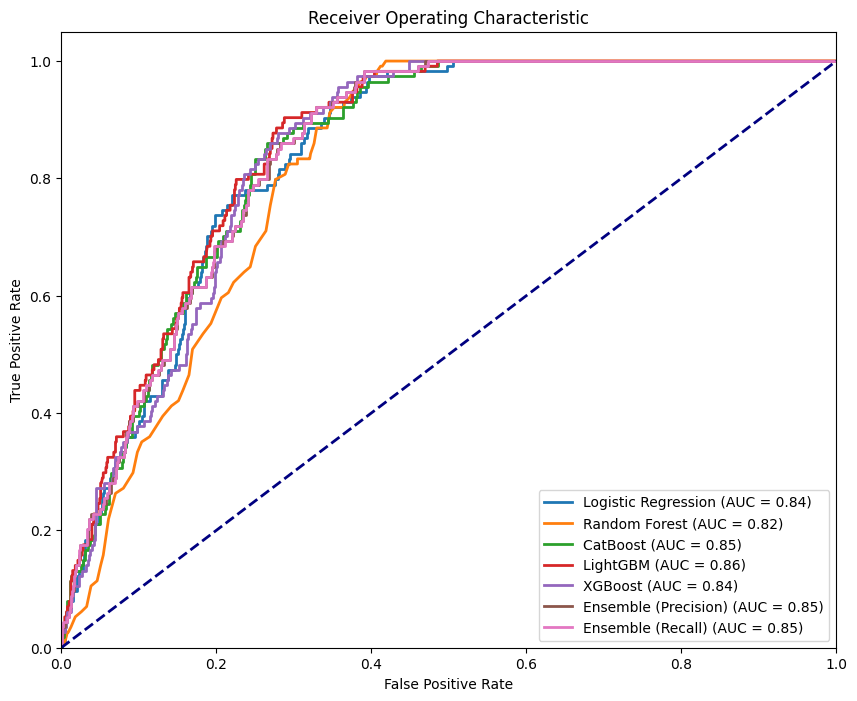

In [7]:
# 평가 지표 계산 함수
def evaluate_model(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # 혼동 행렬로부터 계산
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    return {
        'Confusion Matrix': conf_matrix.tolist(),
        'Accuracy': accuracy,
        'Precision': precision,
        'Positive Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1,
    }

# 결과를 저장할 리스트 초기화
results = []
probas = []

# 각 모델 학습 및 평가
for name, model in models:
    # 학습
    model.fit(train_x, train_y)
    
    # 예측
    valid_y_pred = model.predict(valid_x)
    valid_y_proba = model.predict_proba(valid_x)[:, 1]  # 양성 클래스의 확률만 저장
    
    # 평가
    metrics = evaluate_model(valid_y, valid_y_pred)
    metrics.update({
        'Model': name,
        'y_true': valid_y,
        'y_scores': valid_y_proba
    })
    
    results.append(metrics)
    probas.append(valid_y_proba)

# DataFrame 생성
results_df = pd.DataFrame(results)

# Precision과 Positive Recall 기반 가중치 계산
weights_precision = results_df['Precision'] / results_df['Precision'].sum()
weights_recall = results_df['Positive Recall'] / results_df['Positive Recall'].sum()
results_df['Weight (Precision)'] = weights_precision
results_df['Weight (Recall)'] = weights_recall

# Precision 기반 앙상블
weighted_probas_prec = np.average(probas, axis=0, weights=weights_precision)
valid_y_pred_ens_prec = (weighted_probas_prec >= 0.5).astype(int)

# Recall 기반 앙상블
weighted_probas_rec = np.average(probas, axis=0, weights=weights_recall)
valid_y_pred_ens_rec = (weighted_probas_rec >= 0.5).astype(int)

# 앙상블 모델들의 성능 평가
ensemble_results = []

for ens_name, valid_y_pred_ens, weighted_probas_ens in [("Ensemble (Precision)", valid_y_pred_ens_prec, weighted_probas_prec), 
                                                        ("Ensemble (Recall)", valid_y_pred_ens_rec, weighted_probas_rec)]:
    metrics_ens = evaluate_model(valid_y, valid_y_pred_ens)
    metrics_ens.update({
        'Model': ens_name,
        'Weight (Precision)': np.nan,
        'Weight (Recall)': np.nan,
        'y_true': valid_y,
        'y_scores': weighted_probas_ens
    })
    ensemble_results.append(metrics_ens)

# 결과 DataFrame에 앙상블 결과 추가
results_df = pd.concat([results_df, pd.DataFrame(ensemble_results)], ignore_index=True)

# AUC 값을 저장할 딕셔너리 초기화
auc_values = {}

# ROC 커브와 AUC 추가
plt.figure(figsize=(10, 8))


for index, row in results_df.iterrows():
    if pd.isna(row['y_true']).any() or pd.isna(row['y_scores']).any():
        continue  # y_true 또는 y_scores에 NaN이 있으면 건너뜀
    y_true = row['y_true']
    y_scores = row['y_scores']
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    auc_values[row['Model']] = roc_auc
    plt.plot(fpr, tpr, lw=2, label=f"{row['Model']} (AUC = {roc_auc:.2f})")

# AUC 값을 results_df에 추가
results_df['AUC'] = results_df['Model'].map(auc_values)

# 특정 열(y_true, y_scores) 제외하고 결과 출력
print("\n=== Model Results ===")
print(results_df.drop(columns=['y_true', 'y_scores']).to_string(index=False))


# ROC 커브 그리기
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [8]:
results_df

,Confusion Matrix,Accuracy,Precision,Positive Recall,Specificity,F1-Score,Model,y_true,y_scores,Weight (Precision),Weight (Recall),AUC
0,"[[580, 306], [11, 103]]",0.683,0.251834,0.903509,0.654628,0.393881,Logistic Regression,9785583 0 4902112 0 11044333 0 8470...,"[0.001033288062296608, 0.8023023079664634, 0.0...",0.200598,0.199226,0.843006
1,"[[588, 298], [13, 101]]",0.689,0.253133,0.885965,0.663657,0.393762,Random Forest,9785583 0 4902112 0 11044333 0 8470...,"[0.0, 0.85, 0.0, 0.85, 0.62, 0.45, 0.89, 0.72,...",0.201633,0.195358,0.819755
2,"[[568, 318], [11, 103]]",0.671,0.244656,0.903509,0.641084,0.385047,CatBoost,9785583 0 4902112 0 11044333 0 8470...,"[0.0013940704763991578, 0.8243609026469375, 0....",0.194880,0.199226,0.846778
3,"[[563, 323], [8, 106]]",0.669,0.247086,0.929825,0.635440,0.390424,LightGBM,9785583 0 4902112 0 11044333 0 8470...,"[0.002134214444858523, 0.8086053974718306, 0.0...",0.196816,0.205029,0.855233
4,"[[588, 298], [10, 104]]",0.692,0.258706,0.912281,0.663657,0.403101,XGBoost,9785583 0 4902112 0 11044333 0 8470...,"[0.0012516512, 0.79365623, 0.0035636178, 0.751...",0.206072,0.201161,0.844392
5,"[[579, 307], [9, 105]]",0.684,0.254854,0.921053,0.653499,0.399240,Ensemble (Precision),9785583 0 4902112 0 11044333 0 8470...,"[0.0011569316702290694, 0.8156773451969566, 0....",NaN,NaN,0.846709
6,"[[577, 309], [9, 105]]",0.682,0.253623,0.921053,0.651242,0.397727,Ensemble (Recall),9785583 0 4902112 0 11044333 0 8470...,"[0.0011729523910389156, 0.8155681445693803, 0....",NaN,NaN,0.847095
